### 지금 필요한 Llamagen 파일들: (for running VQVAE Model purposes)
1. tokenizer/tokenizer_image/vq_model.py
2. dataset/augmentation.py (for "crop" operation)
3. pretrained_models/

In [106]:
import torch
import torch.nn.functional as F

import numpy as np
from PIL import Image

from tokenizer.tokenizer_image.vq_model import VQ_models
from dataset.augmentation import center_crop_arr

In [107]:
import invops
from invops.aug.mix import OperationTree

In [108]:
torch.cuda.is_available()

True

In [109]:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 2060'

In [110]:
image_path = "assets/newyork.jpg"
output_dir = "output_vq_demo" #don't need this for visualization
suffix = "tokenizer_image" 
vq_model = "VQ-16" # 16*16 tokens
vq_ckpt = "pretrained_models/vq_ds16_c2i.pt" # pretrained VQVAE Model
codebook_size = 16384
codebook_embed_dim = 8
image_size = 512
seed = 0


In [111]:
#Model Setup
torch.manual_seed(0) #Set seed
torch.set_grad_enabled(False) #no grads needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VQ_models[vq_model](codebook_size = codebook_size
                            , codebook_embed_dim = codebook_embed_dim).to(device)
model.to(device)
model.eval()

checkpoint = torch.load(vq_ckpt, map_location=device)
if "ema" in checkpoint:  # ema
    model_weight = checkpoint["ema"]
elif "model" in checkpoint:  # ddp
    model_weight = checkpoint["model"]
elif "state_dict" in checkpoint:
    model_weight = checkpoint["state_dict"]
else:
    raise Exception("please check model weight")
model.load_state_dict(model_weight)
del checkpoint

In [112]:
def VQVAE_Output(image_path):
    pil_image = Image.open(image_path).convert("RGB")
    img = center_crop_arr(pil_image, image_size) #size에 맞게 변형

    img = np.array(img)/255.0

    x = 2.0 * img - 1.0 #x is value between -1 and 1
    x = torch.tensor(x)
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)
    x_input = x.float().to("cuda")


    # inference
    with torch.no_grad():
        latent, _, [_, _, indices] = model.encode(x_input)
        output = model.decode_code(indices, latent.shape) # output value is between [-1, 1]

    # postprocess
    output = F.interpolate(output, size=[image_size, image_size], mode='bicubic').permute(0, 2, 3, 1)[0]
    sample = torch.clamp(127.5 * output + 128.0, 0, 255).to("cpu", dtype=torch.uint8).numpy()
    return sample


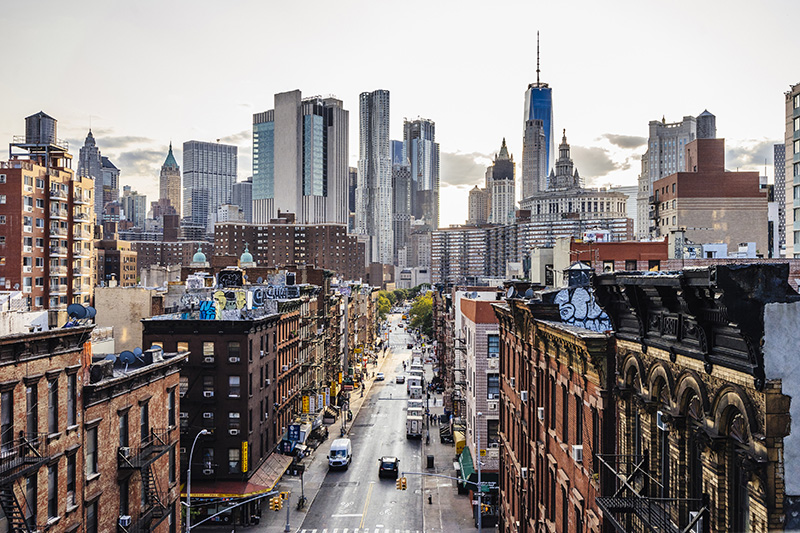

In [113]:
Image.open(image_path).convert("RGB")

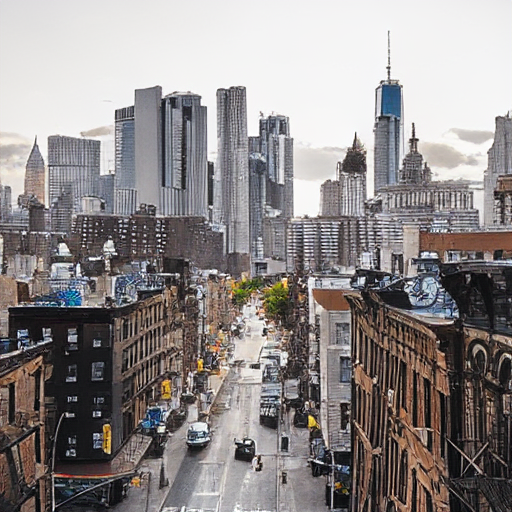

In [114]:
sample_image = Image.fromarray(VQVAE_Output(image_path = image_path))

display(sample_image)

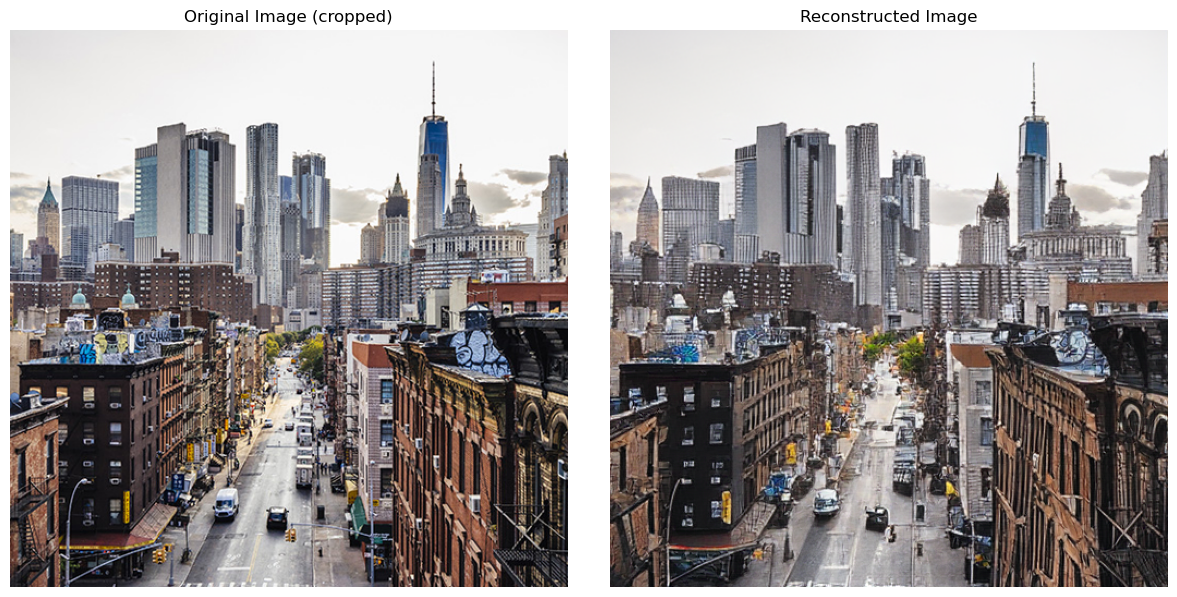

In [116]:
import matplotlib.pyplot as plt

original_image = Image.open(image_path).convert("RGB")
img = center_crop_arr(original_image, image_size) #size에 맞게 변형
sample_image = Image.fromarray(VQVAE_Output(image_path = image_path))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

fig.tight_layout(pad=0)

# Display the original image
axs[0].imshow(img)
axs[0].set_title("Original Image (cropped)")
axs[0].axis('off')

# Display the reconstructed image
axs[1].imshow(sample_image)
axs[1].set_title("Reconstructed Image")
axs[1].axis('off')

plt.show()

In [117]:
#For Future purposes
import matplotlib.pyplot as plt
from invops.aug.mix import OperationTree

img = Image.open(image_path)
img = center_crop_arr(img, 512) #crop 512*512

In [118]:
tree = OperationTree.from_yaml("sample.yaml")

In [119]:
tree.build_rec_all()
print([x.timestep for x in tree._noise_list])

[0.2, 0.4, 0.6, 0.8, 1.0]


In [120]:
from PIL import Image

out = tree(img, True)
print(out.keys())

dict_keys(['orig', 'pre', '1_downsize', '1_multi_0', '1_single_0', '2_downsize', '2_multi_0', '2_single_0', '3_downsize', '3_multi_0', '3_single_0', '4_downsize', '4_multi_0', '4_single_0', '5_downsize', '5_multi_0', '5_single_0', 'output'])


In [121]:
tree.export_yaml("./sample.yaml")

In [129]:
def show_arr(arr: np.ndarray):
    if arr.dtype != np.uint8:
        # arr = np.clip(arr, 0, 255).astype(np.uint8)
        arr = np.clip(arr, -1, 1)
        arr = (arr + 1.0) * 127.5
    image = Image.fromarray(arr.astype(np.uint8))
    return image
    #display(image.resize((512, 512)))

In [132]:
fig, axs = plt.subplots(len(out), 2, figsize=(12, 6 * len(out)))
fig.tight_layout(pad=0)

for i, (key, value) in enumerate(out.items()):
    original_image = show_arr(value)
    temp_path = 'asdf.jpg'
    image_size, _ = original_image.size #change size for VQVAE generation

    original_image.save(temp_path)
    sample_image = Image.fromarray(VQVAE_Output(temp_path))
    #display(original_image)
    #display(sample_image)

    axs[i, 0].imshow(original_image)
    axs[i, 0].set_title("Original Image")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(sample_image)
    axs[i, 1].set_title("Reconstructed Image")
    axs[i, 1].axis('off')

plt.show()

RuntimeError: Calculated padded input size per channel: (2 x 2). Kernel size: (3 x 3). Kernel size can't be greater than actual input size